In [1]:
from PIL import Image
import argparse
import torchvision.transforms.functional as F_
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

import sys
import os
import argparse
import random
import pickle

module_path = os.path.abspath(os.path.join('/data/data_ustv/home/ydou8/Course/truly_shift_invariant_cnns/cifar10_training/'))
if module_path not in sys.path:
    sys.path.append(module_path)



import model_classes

from utils.model_functions import compute_num_params
from utils.plot_functions import plot_save_train_val_list
from utils.file_functions import create_folders_direct_path
from utils.for_circular_pad_exps.get_dataloaders_circular import get_dataloaders_circular

from utils.for_circular_pad_exps.train_validate_circular import train_and_validate_circular_all_epochs, evaluate_circular, evaluate_circular_flip, evaluate_circular_random_erase


In [58]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [59]:
test_data = unpickle('/data/data_ustv/home/ydou8/Course/CS766/data/cifar-10-batches-py/test_batch')

In [60]:
cifar_test_filenames = test_data[b'filenames']
cifar_test_labels = test_data[b'labels']
cifar_test_data = test_data[b'data']
cifar_test_data  = cifar_test_data .reshape((len(cifar_test_data ), 3, 32, 32)).transpose(0, 2, 3, 1)

In [216]:
idx = 7

In [232]:
cifar_test_filenames[idx], cifar_test_labels[idx]

(b'green_frog_s_000634.png', 6)

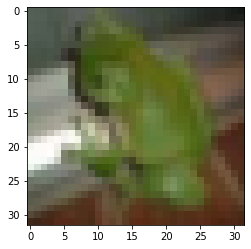

In [233]:
plt.imshow(cifar_test_data[idx])
plt.savefig(cifar_test_filenames[idx])

In [219]:
mean=[0.4914, 0.4822, 0.4465]
std=[0.247, 0.243, 0.261]


#img = Image.open("/data/data_ustv/home/ydou8/Course/CS766/data/ILSVRC2012/val/n04228054/ILSVRC2012_val_00000568.JPEG")
img = Image.fromarray(cifar_test_data[idx ].astype('uint8'), 'RGB')
#img = F_.resize(img, (32, 32), interpolation=2)
img = F_.to_tensor(img)
input = (F_.normalize(img, mean=mean, std=std)[None,:]).cuda()
input_ = img[None,:].cuda()

In [220]:
shift = np.random.randint(-3, 3, 2)
                
shifted_image_batch = torch.roll(input, shifts = (shift[0], shift[1]), dims = (2, 3))
shifted_image_batch_ = torch.roll(input_, shifts = (shift[0], shift[1]), dims = (2, 3))

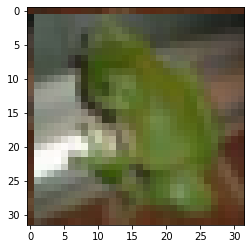

In [234]:
plt.imshow(shifted_image_batch_[0].permute(1, 2,0).cpu().numpy())
plt.savefig('shifted_'+cifar_test_filenames[idx].decode('utf-8'))

In [222]:
from model_classes.lpf_models_up.resnet import resnet18_lpf_up

In [223]:
model_dict = {'conv_pad_type': 'circular',
                  'dataset_to_train': 'cifar10',
                  'pretrained': False,
                 'filter_size': 3,
                 'layer_channels':[64, 128, 256, 512]}

In [224]:
weights_ = '/data/data_ustv/home/ydou8/Course/truly_shift_invariant_cnns/model_ouput/models/model_and_optim_checkpoint.pt'
weights = torch.load(weights_)
model.load_state_dict(weights['model'])

<All keys matched successfully>

In [225]:
name_ = ['airplane', 'automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

In [226]:
model.eval()
with torch.no_grad():
    output_labels = model(shifted_image_batch.cpu())
    output = torch.nn.Softmax(dim=1)(output_labels )
    output_sort, output_argsort = torch.sort(output, dim=1, descending=True)

In [227]:
output_sort, output_argsort

(tensor([[0.9145, 0.0644, 0.0044, 0.0042, 0.0036, 0.0023, 0.0017, 0.0017, 0.0017,
          0.0016]]),
 tensor([[6, 2, 0, 5, 8, 4, 7, 3, 9, 1]]))

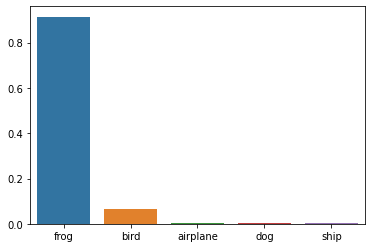

In [228]:
fig, ax = plt.subplots()
ax = sns.barplot(x=[name_[i] for i in output_argsort.numpy()[0][:5] ], y=output_sort.numpy()[0][:5])
plt.savefig('shifted_bar_'+cifar_test_filenames[idx].decode('utf-8'))

In [229]:
model.eval()
with torch.no_grad():
    output_labels = model(input.cpu())

In [230]:
output = torch.nn.Softmax(dim=1)(output_labels )
output_sort, output_argsort = torch.sort(output, dim=1, descending=True)
output_sort, output_argsort

(tensor([[9.8230e-01, 8.8334e-03, 2.2168e-03, 1.2321e-03, 1.0277e-03, 9.4497e-04,
          9.3071e-04, 8.8996e-04, 8.3943e-04, 7.8356e-04]]),
 tensor([[6, 2, 5, 4, 0, 8, 9, 1, 7, 3]]))

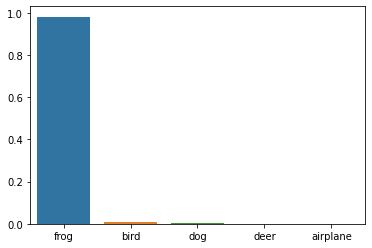

In [231]:
fig, ax = plt.subplots()
ax = sns.barplot(x=[name_[i] for i in output_argsort.numpy()[0][:5] ], y=output_sort.numpy()[0][:5])
plt.savefig('bar_'+cifar_test_filenames[idx].decode('utf-8'))